- **Author:** [Dace Apšvalka](https://www.mrc-cbu.cam.ac.uk/people/dace.apsvalka/) 
- **Date:** August 2026  
- **conda environment**: [mri conda environment](../mri_environment.yml).


# MRI Data Manipulation With NiBabel and Nilearn

In neuroimaging research, the ability to efficiently load, inspect, and manipulate MRI data is essential for both exploration and analysis. Python libraries such as [NiBabel](http://nipy.org/nibabel/) and [Nilearn](https://nilearn.github.io/stable/index.html) provide powerful tools for handling neuroimaging data in common formats like NIfTI.  
In this tutorial, we will explore how to use these libraries to perform fundamental operations on MRI data, including loading images, inspecting headers, working with affine transformations, and manipulating the data itself.

----------

**Table of contents**
1. Import required packages and set up the some stuff   
2. Loading and inspecting images with NiBabel  
   2.1. Header  
   2.2. Data   
   2.3. Affine   
3. Image manipulation with NiLearn  
   3.1. Plotting images  
   3.2. Computing the mean image  
   3.3. Resampling one image to match another  
   3.4. Smooth an image  
   3.5. Thresholding an image  
   3.6. Plotting a time course  
4. EXERCISE    


-------

## Import required packages and set up the some stuff

In [1]:
import nibabel as nib
import nilearn as nl

import nilearn.plotting
import nilearn.image

from bids import BIDSLayout

import matplotlib.pyplot as plt
import pylab as plt

import numpy as np

Throughout the examples, we will work with one subject’s **anatomical** and **functional** images, which we will retrieve from our BIDS dataset.

In this example, we’ll retrieve them as filenames (i.e., plain strings), not as `BIDSFile` objects. This is convenient when working directly with libraries like `nibabel` or `nilearn`, which expect standard file paths.

In [2]:
fmri_data_dir = '../example_data/FaceRecognition/data'

# Initialize the BIDS layout
layout = BIDSLayout(fmri_data_dir)

# Get subject's T1w image and the image of the first functional run
anat_filename = layout.get(subject='15', extension='nii.gz', datatype='anat', return_type='filename')[0]
bold_filename = layout.get(subject='15', run='01', extension='nii.gz', suffix='bold', return_type='filename')[0]

# Print the file names
print("Subject's anatomical image", anat_filename)
print("Subject's functional image", bold_filename)

Subject's anatomical image /imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/data/sub-15/ses-mri/anat/sub-15_ses-mri_T1w.nii.gz
Subject's functional image /imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/data/sub-15/ses-mri/func/sub-15_ses-mri_task-facerecognition_run-01_bold.nii.gz


## Loading and inspecting images with NiBabel

`nibabel` is the core Python library for reading and writing neuroimaging data formats, including NIfTI. It provides powerful tools to load image files, access metadata, and manipulate image data arrays using standard NumPy syntax.  
Many other neuroimaging libraries, such as `PyBIDS`, `DIPY`, and `nilearn`, build on top of `nibabel`. So, learning the basics of `nibabel` is essential for working effectively with neuroimaging data in Python.

Let’s start by using `nibabel`'s `load()` function to create image objects from our NIfTI files:

In [3]:
anat_image = nib.load(anat_filename)
bold_image = nib.load(bold_filename)

print("anat_image datatype:" ,type(anat_image))
print("bold_image datatype:" ,type(bold_image))

anat_image datatype: <class 'nibabel.nifti1.Nifti1Image'>
bold_image datatype: <class 'nibabel.nifti1.Nifti1Image'>


Loading a NIfTI file with `nibabel` gives us a special **image object** that contains all the information stored in the file, both the actual voxel data and associated metadata.

In Python, these pieces of information are accessed through **attributes** of the object.
💡 To explore all available attributes interactively in Jupyter, type, e.g., `anat_image.` and press `Tab`.

We’ll focus on three of the most important attributes:
- Header (`.header`) – Metadata describing the structure of the image (e.g., dimensions, voxel size, data type)
- Data (`.get_fdata()`) – Returns the actual image data as a NumPy array
- Affine (`.affine`) – A matrix that maps voxel coordinates to real-world space

### Header

The header contains important metadata about the image. This includes:  
- Image dimensions – Stored in `dim`:
  - `dim[0]` is the number of dimensions (e.g., 3 for T1w, 4 for BOLD)
  - `dim[1:4]` give the number of voxels in the x, y, and z directions
  - `dim[4]` if present, gives the number of time points (e.g., for BOLD)
- Voxel sizes – Stored in `pixdim`:
  - `pixdim[1:4]` are the voxel sizes in millimetres along the x, y, and z axes
  - `pixdim[4]` is the repetition time (TR) in seconds (relevant only for 4D data like BOLD)
- Data type – The type of data stored in the voxels (e.g., `int16`, `float32`)
- Spatial orientation – Information that maps voxel indices to real-world (e.g., scanner or MNI, show in `qform_code`) space. This is encoded in the `qform` and `sform` fields, and used to compute the `.affine` matrix, which we will examine later.

In [4]:
# Inspect the header of the functional image
bold_header = bold_image.header
print(bold_header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 57
dim             : [  4  64  64  33 208   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.   3.   3.   3.9  2.   0.   0.   0. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : alternating increasing
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'TE=30;Time=101103.117;phase=1'
aux_file        : b'V'
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0075445473
quatern_c       : -0.95413244
quatern_d       : -0.29831544
qoffset_x       : 96.60478
qoffset

`bold_header` is a Python **dictionary-like object**. It behaves similarly to a dictionary, meaning it holds **key–value pairs**.  

You can access specific values using a key:

In [5]:
print(bold_header['dim'])

[  4  64  64  33 208   1   1   1]


You can also use built-in methods that `nibabel` provides to retrieve common metadata, for example:

In [6]:
print(bold_header.get_data_shape())  # Shape of the image array
print(bold_header.get_n_slices())    # Number of slices (z-dimension)
print(bold_header.get_zooms())       # Voxel size and TR (voxel spacing per axis)


(64, 64, 33, 208)
33
(3.0, 3.0, 3.9, 2.0)


💡 **Note:** If all you want is the **shape of the image data**, you can get it directly from the image object itself without calling the header:

In [7]:
bold_image.shape 

(64, 64, 33, 208)

### Data

As demonstrated above, the header contains valuable metadata about the MRI image. Now let’s move on to accessing the actual voxel data, which we can do using the `.get_fdata()` method:

In [8]:
anat_data = anat_image.get_fdata()
bold_data = bold_image.get_fdata()

This method returns a `NumPy` array containing the image data. Let’s inspect the anatomical data:

In [9]:
print(anat_data)

[[[14. 21. 27. ...  2.  0.  0.]
  [18. 21. 25. ...  1.  1.  0.]
  [20. 37. 27. ...  1.  2.  0.]
  ...
  [ 8.  1.  4. ...  3.  0.  0.]
  [ 7.  4.  2. ...  1.  1.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 [[22.  7. 36. ...  1.  1.  0.]
  [ 7. 43.  7. ...  3.  0.  0.]
  [ 7. 37. 18. ...  1.  2.  0.]
  ...
  [ 3.  8.  8. ...  0.  1.  0.]
  [ 3.  2.  5. ...  0.  1.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 [[53. 21.  2. ...  1.  2.  0.]
  [29. 24. 18. ...  1.  1.  0.]
  [ 2. 26. 18. ...  0.  0.  0.]
  ...
  [ 2.  9.  3. ...  2.  2.  0.]
  [ 5.  9.  4. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 ...

 [[22. 35.  8. ...  2.  2.  0.]
  [27.  8. 13. ...  0.  1.  0.]
  [34. 15. 15. ...  1.  1.  0.]
  ...
  [ 1.  2.  1. ...  0.  3.  0.]
  [ 1.  2.  2. ...  1.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 [[15. 20. 10. ...  1.  2.  0.]
  [28. 27. 35. ...  1.  1.  0.]
  [27. 15.  9. ...  1.  3.  0.]
  ...
  [ 4.  2.  1. ...  2.  2.  0.]
  [ 2.  1.  5. ...  2.  1.  0.]
  [ 0.  0.  0. ...  0.  0.  

This is a **multidimensional array** representing the image in voxel intensity values.

To find out how many dimensions the array has, we can use the `.ndim` attribute:

In [10]:
print(f"T1w image dimensions: {anat_data.ndim}")

T1w image dimensions: 3


To see how large each dimension is (i.e., how many voxels along each axis), use `.shape`:

In [11]:
print(f"T1w image shape is {anat_data.shape}")
print(f"BOLD image shape is {bold_data.shape}")

T1w image shape is (192, 256, 256)
BOLD image shape is (64, 64, 33, 208)



A T1w image has shape (x, y, z) — a 3D anatomical volume.  
A functional image has shape (x, y, z, t) — a 4D volume, where `t` is the number of timepoints (volumes collected over time during the fMRI scan).

For the BOLD image, the brain was scanned in 33 axial slices with a resolution of 64 x 64 voxels per slice. This means each 3D volume contains: 64 * 64 * 33 = 135,168 voxels in total. In addition, the scan was repeated 208 times, resulting in 208 3D volumes captured over time. Each voxel contains a time series of 208 values — one per volume — representing changes in the BOLD signal over time.

Now, let’s examine the type of data stored inside the image array.

💡 **Note:** Python uses zero-based indexing, which means that counting starts at 0. So the voxel at index `(0, 0, 0)` is actually the first voxel in each dimension.

To access the **value of a specific voxel**, use standard NumPy-style indexing with the syntax: `data[x, y, z]`.

For example, to inspect the voxel at **(20, 60, 30)** — which corresponds to the **21st, 61st, and 31st** voxel in human-friendly counting — you can write:

In [12]:
anat_voxel_value = anat_data[20, 60, 30]

print(f"Voxel value at (20, 60, 30) is {anat_voxel_value}")

Voxel value at (20, 60, 30) is 9.0


This returns a single number for 3D image or a full time series for 4D images like BOLD.

In [13]:
bold_voxel_values = bold_data[20, 60, 30]
print(f"BOLD voxel values at (20, 60, 50) {bold_voxel_values}")

BOLD voxel values at (20, 60, 50) [29. 40. 58. 53. 45. 61. 51. 42. 42. 36. 54. 39. 43. 41. 46. 60. 56. 50.
 43. 46. 54. 50. 39. 38. 54. 65. 59. 51. 56. 61. 56. 57. 39. 43. 37. 39.
 51. 54. 62. 43. 38. 82. 52. 65. 53. 57. 56. 56. 51. 40. 52. 58. 41. 49.
 42. 50. 44. 62. 48. 40. 43. 52. 51. 47. 54. 40. 58. 46. 28. 62. 39. 58.
 48. 41. 56. 58. 55. 37. 42. 61. 45. 54. 44. 33. 50. 55. 54. 40. 71. 43.
 40. 67. 54. 49. 53. 65. 39. 61. 68. 48. 64. 53. 55. 64. 54. 60. 55. 48.
 37. 28. 41. 44. 49. 43. 58. 33. 42. 39. 65. 48. 44. 49. 45. 39. 59. 30.
 28. 37. 58. 50. 37. 45. 60. 47. 41. 50. 50. 53. 44. 51. 29. 56. 59. 37.
 39. 53. 54. 68. 54. 34. 54. 27. 51. 49. 64. 32. 43. 53. 55. 43. 60. 44.
 44. 69. 50. 52. 53. 56. 54. 64. 48. 46. 43. 42. 28. 44. 54. 29. 64. 46.
 54. 65. 67. 34. 44. 46. 61. 37. 53. 58. 36. 49. 41. 47. 53. 47. 55. 57.
 50. 39. 43. 50. 47. 56. 54. 59. 41. 48.]


We can also extract **data from a slice** of the 3D image for visualisation or analysis.
Slicing does exactly what it sounds like: it allows us to cut through the volume along one axis and extract a 2D plane.

For example, slicing along the **z-axis** gives us an **axial view** — a horizontal slice through the brain, as if you're looking from the top down.

Let’s extract the 150th axial slice of the anatomical image:

In [14]:
anat_z_slice = anat_data[:, :, 150]
print(anat_z_slice)

[[0. 1. 2. ... 4. 4. 0.]
 [4. 2. 2. ... 0. 4. 0.]
 [4. 7. 1. ... 6. 3. 0.]
 ...
 [1. 3. 3. ... 0. 2. 0.]
 [3. 2. 3. ... 2. 2. 0.]
 [5. 2. 1. ... 1. 3. 0.]]


We can view this slice using `matplotlib`:

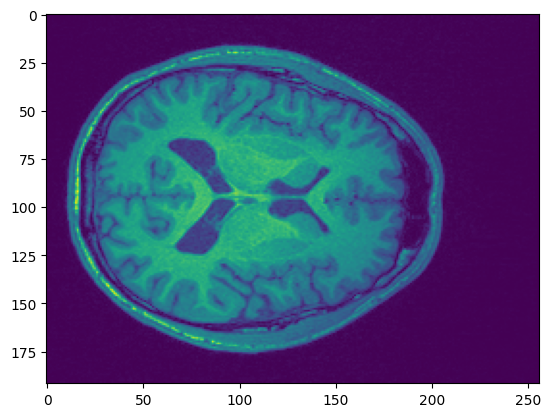

In [15]:
plt.imshow(anat_z_slice)

Let's take a look at the 100th slice from each of the three dimensions of the anatomical image: sagittal (x-axis), coronal (y-axis), and axial (z-axis).

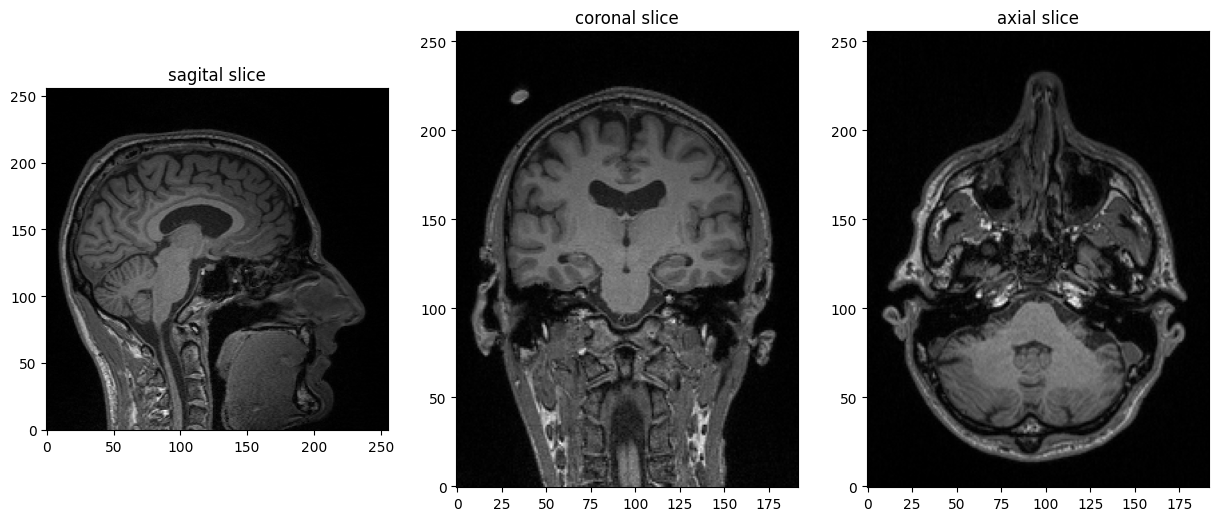

In [16]:
slices = {
  'sagital slice': anat_data[100, :, :], 
  'coronal slice': anat_data[:, 100, :], 
  'axial slice': anat_data[:, :, 100]}

fig, axes = plt.subplots(1, len(slices), figsize=(15,15))

for i, slice in enumerate(slices.values()):
    axes[i].imshow(slice.T, cmap="gray", origin="lower") # The .T (transpose) and origin='lower' make the image appear in a more intuitive orientation for visualisation
    axes[i].set_title(list(slices.keys())[i])


### Affine

The final important piece of metadata associated with an image file is the **affine matrix**, a 4x4 matrix which defines how the voxel grid of the image is positioned, oriented, and scaled relative to the scanner or reference space. Without the affine matrix, the voxel coordinates are just abstract numbers. With it, you know how the image data aligns with the real world, enabling comparisons and transformations between different images or scans.

For example, if we have the voxel coordinate (26, 30, 16), without additional information, we wouldn’t know if this position is on the left or right side of the brain, or if it came from the left or right of the scanner. This is because the scanner can collect voxel data in almost any arbitrary position and orientation within the magnet.

For example, BOLD images are typically acquired at a different angle and with smaller coverage than T1-weighted anatomical images, resulting in different voxel sizes, different bounding boxes, and different orientation in space. So the voxel (26, 30, 16) in the BOLD image doesn’t refer to the same brain region as the same voxel coordinate in the T1w image.

<img align="centre" src="https://nipy.org/nibabel/_images/localizer.png" width="50%">

The affine matrix solves this problem. It allows us to map any voxel coordinate (like (26, 30, 16)) to a location in physical space (measured in millimetres), and thus align images from different scans.

The origin of the scanner coordinate system is the magnet isocenter: the physical center of the scanner bore. All spatial coordinates (in mm) are measured relative to this point. If the subject is lying head first, face up, the coordinate axes align with the subject’s anatomy as follows:

- X (left–right): increases from **left to right** side of the subject
- Y (posterior–anterior, scanner's floor-ceiling): increases from **back to front** of the subject
- Z (inferior–superior, scanner's bore): increases from **neck to top of the head**

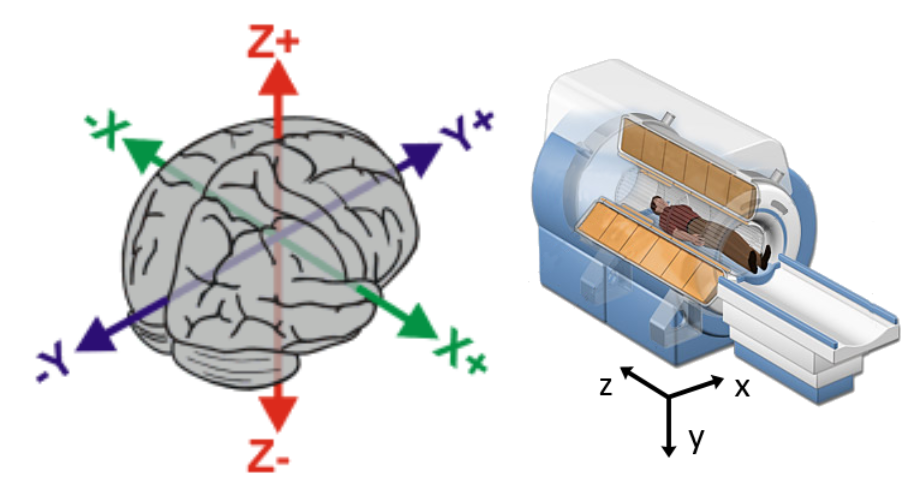

Below is the affine matrix for our anatomical data. This matrix relates the **voxel coordinates** to the **world (scanner) coordinates**.

In [17]:
anat_affine = anat_image.affine
print(anat_affine)

[[ 9.95735466e-01  3.48999910e-02  8.53650272e-02 -1.08332054e+02]
 [-3.47723439e-02  9.99390841e-01 -2.98100128e-03 -9.13446350e+01]
 [-8.54168236e-02  0.00000000e+00  9.96345341e-01 -1.23124344e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In the NIfTI image header, the `qform_code` and `sform_code` fields indicate which coordinate space the affine transformation refers to. These codes tell us how to interpret the voxel-to-world mapping defined by affine matrix.

Here are the common code values:

| Code | Label     | Meaning                       |
|------|-----------|--------------------------------|
| 0    | unknown   | Not specified; the affine should be ignored              |
| 1    | scanner   | Coordinates are in scanner (device) space    |
| 2    | aligned   | Aligned to another scan (e.g., functional to anatomical)|
| 3    | talairach | In Talairach atlas space  |
| 4    | mni       | In MNI (Montreal Neurological Institute) space        |


In [18]:
print(bold_header['qform_code'])
print(bold_header['sform_code'])

1
1


💡 **Note:** When you print the `nibabel` image header, the output includes a human-readable summary. For example, fields like `qform_code` and `sform_code` are shown with descriptive labels such as `scanner` or `aligned`. This is done internally by `nibabel`, which maps the underlying integer codes to labels only for display purposes. However, this mapping is not directly accessible from the header object itself.

The parameters in the affine matrix allow us to determine the position of any voxel in the image relative to a reference space (e.g., the scanner bore).

Let’s examine how far the centre of the voxel grid in the anatomical image is shifted from the scanner's isocentre.

Let’s examine how much the centre of the voxel space in the anatomical image is shifted from the origin of the scanner's isocentre.  
To do this, we will 
1. Compute the voxel-space centre (the middle voxel in each dimension),
2. Convert it to real-world (scanner) coordinates using the affine matrix,
3. Compare it to the scanner isocenter.

This will tell us where the centre of the image lies in scanner space.

In [19]:
# Get the shape of the image data (dimensions of the voxel grid)
data_shape = anat_image.shape

# Calculate the voxel space center (the middle voxel in each dimension)
voxel_center = np.array(data_shape) / 2

# Convert voxel center to reference (scanner) space using the affine matrix
center_in_scanner_space = anat_affine.dot(np.append(voxel_center, 1))[:3]  # Applying affine transformation

# Scanner isocentre (origin) is at (0, 0, 0)
scanner_isocentre = np.array([0, 0, 0])

# Calculate the shift (distance between voxel space center and scanner isocentre) in mm
shift = center_in_scanner_space - scanner_isocentre

print(f"Shift of the anatomical image's voxel center from the scanner isocentre: {shift} mm")


Shift of the anatomical image's voxel center from the scanner isocentre: [ 2.65247297 32.8576794  -3.79215527] mm


`nibabel` also provides a convenient utility function called `apply_affine`, which simplifies the process of applying an affine transformation to voxel coordinates. This gives the same result as manually multiplying the affine matrix.

In [20]:
from nibabel.affines import apply_affine

# Get the shape of the image data (dimensions of the voxel grid)
data_shape = anat_image.shape

# Calculate the voxel space center (the middle voxel in each dimension)
voxel_center = np.array(data_shape) / 2

# Apply the affine transformation to get the center's location in scanner space
shift = apply_affine(anat_image.affine, voxel_center)

print(f"Shift of the anatomical image's voxel center from the scanner isocenter: {shift} mm")


Shift of the anatomical image's voxel center from the scanner isocenter: [ 2.65247297 32.8576794  -3.79215527] mm


This means that the centre of the anatomical image's field of view is **2.6 mm to the right** of the scanner's isocentre, **32.9 mm anterior**, and **3.8 mm inferior** (below) the isocentre.



When an image is registered to a template space, such as the **MNI template**, it receives an affine matrix that maps the voxel coordinates of that image into MNI space. In this space, the origin (0, 0, 0) is defined at the **anterior commissure,** and the axes are standardized across datasets.

Working with MNI-aligned data often involves converting between voxel coordinates and MNI space coordinates. For instance, you might want to retrieve the voxel value at a known MNI location, or determine the MNI coordinates of a voxel of interest.

Let's load an MNI space image from our example pre-processed data:

In [22]:
mni_anat_filename = '../example_data/FaceRecognition/data/derivatives/fmriprep/sub-15/ses-mri/anat/sub-15_ses-mri_space-MNI152NLin6Asym_res-9_desc-preproc_T1w.nii.gz'
mni_anat_image = nib.load(mni_anat_filename)
mni_anat_affine = mni_anat_image.affine


To **convert voxel coordinates into MNI space coordinates**, you can apply the affine matrix of the registered image:

In [23]:
# Specify voxel coordinates to translate (e.g., voxel at (20, 48, 20))
voxel_coords = np.array([20, 48, 20])

# Convert voxel coordinates to MNI space using the affine matrix
mni_coords = apply_affine(mni_anat_affine, voxel_coords)

print(f"MNI coordinates for voxel {voxel_coords} are {mni_coords}")

MNI coordinates for voxel [20 48 20] are [-30.  18. -12.]


To **translate MNI space coordinates back to voxel coordinates**, you need to apply the inverse of the affine matrix:

In [24]:
# Specify MNI coordinates
mni_coords = np.array([-30, 18, -12])

# Calculate the inverse of the affine matrix
affine_inv = np.linalg.inv(mni_anat_affine)

# Convert MNI coordinates to voxel coordinates using the inverse affine
voxel_coords = apply_affine(affine_inv, mni_coords)

print(f"Voxel coordinates for MNI coordinates {mni_coords} are {voxel_coords}")

Voxel coordinates for MNI coordinates [-30  18 -12] are [20. 48. 20.]


🧠 Where is this voxel located in relation to the anterior commissure? 

In [25]:
# import nilearn.plotting

# nl.plotting.plot_anat(mni_anat_image, cut_coords=[ -30, 18, -12])

## Image manipulation with NiLearn

`nilearn` builds on top of `nibabel` and provides higher-level tools for manipulating and visualising neuroimaging data. While `nibabel` is excellent for reading and writing files and working with raw data, `nilearn` makes it much easier to perform common image operations (like computing a mean image, resampling, smoothing, thresholding) and to visualise the results interactively or as static plots.

`nilearn` functions can operate on either filenames (as strings) or `Nifti1Image` objects (from `nibabel`).

### Plotting images

`nilearn` includes several convenient plotting functions for visualising neuroimaging data. The most commonly used are:
- `nilearn.plotting.plot_anat` – Plot anatomical images (in greyscale by default).
- `nilearn.plotting.plot_epi` – Plot functional (EPI) images with noise and low contrast.
- `nilearn.plotting.plot_stat_map` – For plotting statistical maps (e.g., t-maps or z-maps) overlaid on background images.
- `nilearn.plotting.plot_roi` - Plotting regions of interest (ROIs) and masks overlaid on background images.
- `nilearn.plotting.plot_glass_brain` – Projects 3D statistical maps onto a transparent brain outline ("glass brain" view).
- `nilearn.plotting.view_img` – Interactive 3D viewer.

💡 **Note:** When specifying slice positions with the `cut_coords` argument, coordinates are given in real-world space, such as MNI or scanner space, not voxel indices. This means you need to use spatial coordinates instead of voxel locations (e.g., from our example voxel above, that would be [-30, 18, -12] instead of [20, 48, 20]).

### Compute the mean image

If you're using `nibabel` to compute the mean image, you first need to load the image, extract the data, and then compute the mean manually. With `nilearn `, you can achieve the same result in a single line using the `mean_img` function.

In [26]:
# Show the shape of the original 4D BOLD image
print("Shape of the BOLD image:", bold_image.shape)

# Compute the mean image using nilearn
bold_mean_image = nl.image.mean_img(bold_image, copy_header=True)

# Shape of the mean BOLD image
print("Shape of the mean BOLD image:", bold_mean_image.shape)

Shape of the BOLD image: (64, 64, 33, 208)
Shape of the mean BOLD image: (64, 64, 33)


/tmp/ipykernel_1348527/2209333645.py:2: UserWarning: Casting data from int16 to float32
  nl.plotting.plot_roi(


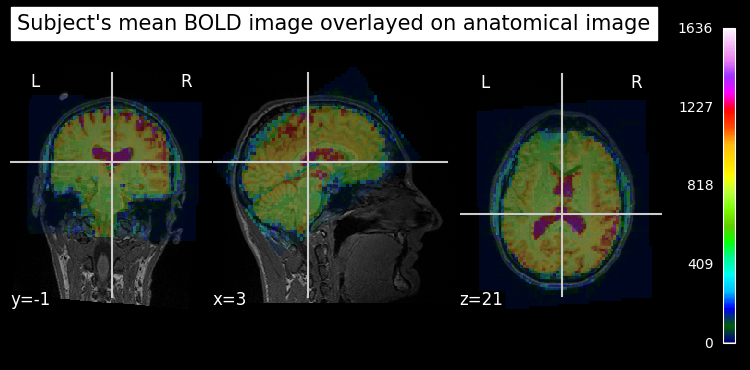

In [27]:
# Plot the mean BOLD image overlayed on the anatomical image
nl.plotting.plot_roi(
  bold_mean_image,
  anat_image, 
  alpha=0.3, 
  title="Subject's mean BOLD image overlayed on anatomical image"
)

### Resample one image to match another

You can resample any image to match the shape, resolution, and affine of another using `resample_to_img`.  
For example, let’s resample an anatomical T1 image to match the dimensions of the mean BOLD image.

In [28]:
# image shapes before resampling
print([bold_mean_image.shape, anat_image.shape])

# Resample the anatomical image to match the mean BOLD image
resampled_anat = nl.image.resample_to_img(anat_image, bold_mean_image, force_resample=True, copy_header=True)

# T1 image shape after resampling
resampled_anat.shape

[(64, 64, 33), (192, 256, 256)]


/tmp/ipykernel_1348527/2582959682.py:5: UserWarning: Casting data from int16 to float32
  resampled_anat = nl.image.resample_to_img(anat_image, bold_mean_image, force_resample=True, copy_header=True)


(64, 64, 33)

/tmp/ipykernel_1348527/208172306.py:2: UserWarning: Casting data from int32 to float32
  nl.plotting.plot_anat(anat_image, title = 'Original anatomical image', dim=-1)


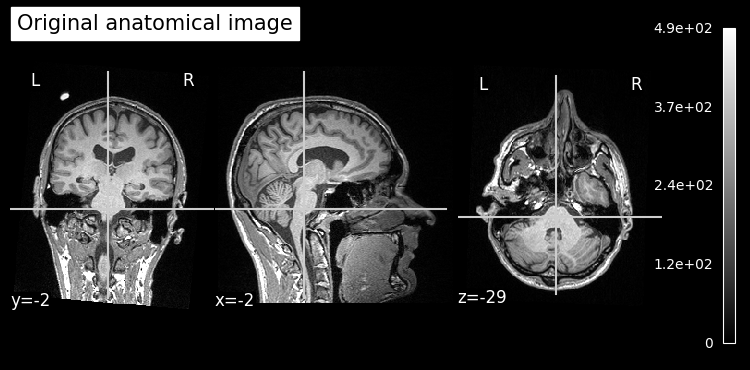

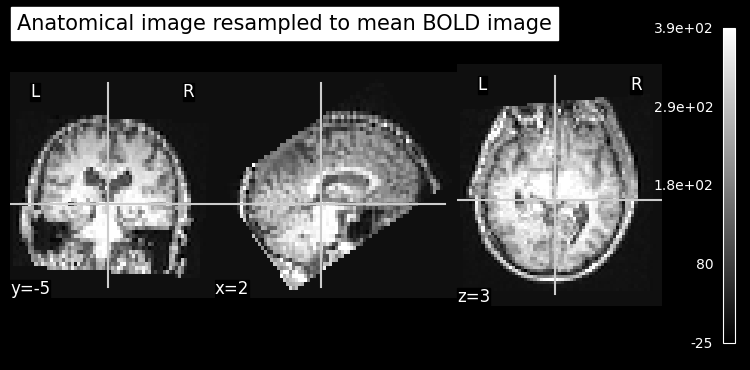

In [29]:
# plot the original and resampled anatomical images
nl.plotting.plot_anat(anat_image, title = 'Original anatomical image', dim=-1)
nl.plotting.plot_anat(resampled_anat, title = 'Anatomical image resampled to mean BOLD image', dim=-1)

### Smooth an image

Smoothing is often used to reduce noise or prepare images for statistical analysis. The `smooth_img` function makes this simple. For example, let’s take the mean image from above and apply smoothing with different full width at half maximum (FWHM) values to see how smoothing affects the image.

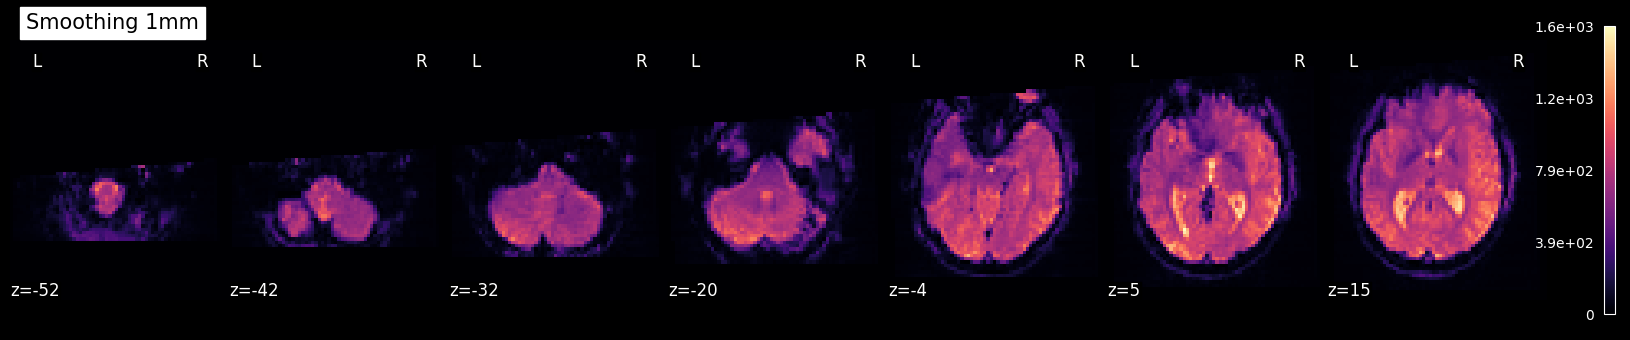

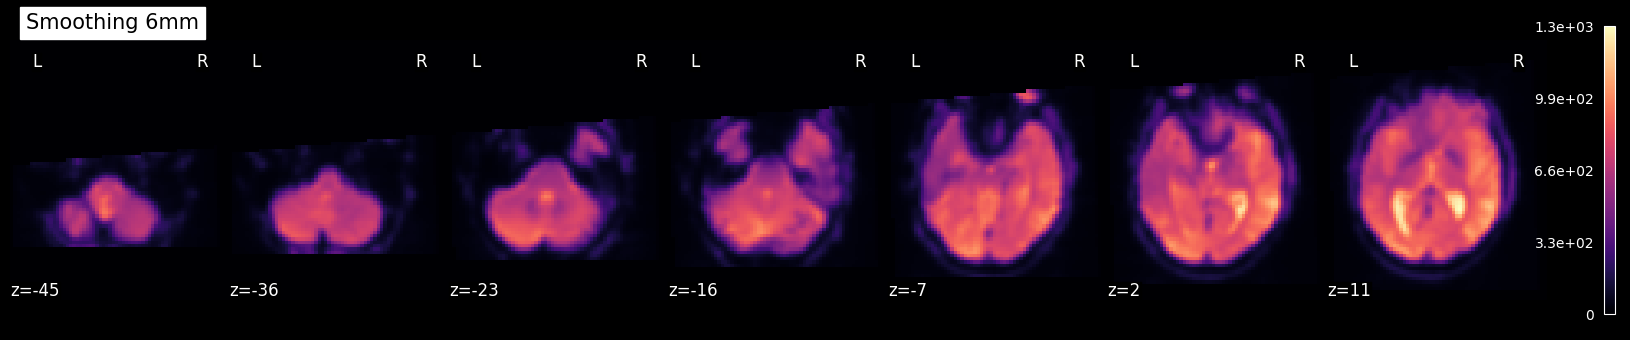

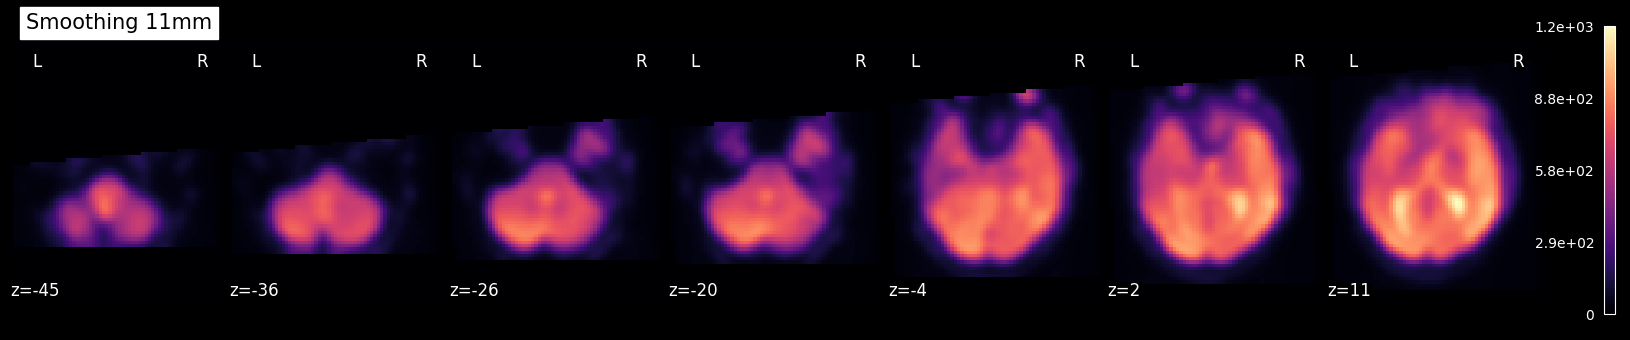

In [30]:
for fwhm in range(1, 12, 5):
  
    smoothed_img = nl.image.smooth_img(bold_mean_image, fwhm)
    
    nl.plotting.plot_epi(
      smoothed_img, 
      title = "Smoothing %imm" % fwhm,
      display_mode = 'z', 
      cmap = 'magma'
      )

### Thresholding an image

Thresholding is a common technique used to highlight the most relevant voxels in an image, for example, those with the strongest activation, signal intensity, or statistical value.  
In `nilearn`, you can use the `threshold_img()` function to apply a threshold to an image either by an absolute value or a percentile.

Let's apply a threshold to the previously computed mean BOLD image to keep only the voxels with values higher than 95% of all voxels.

/tmp/ipykernel_1348527/2588281295.py:1: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  thresholded_img = nl.image.threshold_img(bold_mean_image, threshold='95%')
/imaging/correia/da05/conda/env/mriworkshops/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



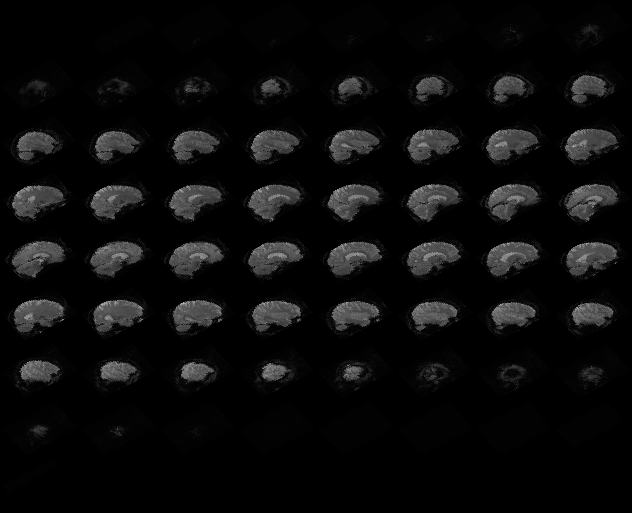
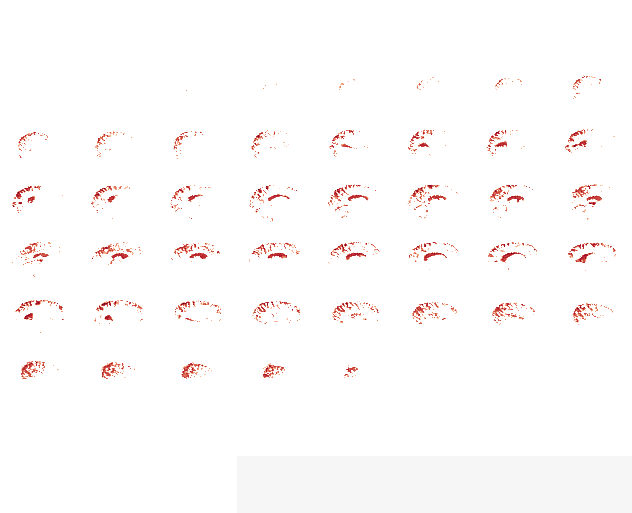

In [31]:
thresholded_img = nl.image.threshold_img(bold_mean_image, threshold='95%')

# let's see how the thresholded image look compared to the original mean image
nl.plotting.view_img(
  thresholded_img, 
  bg_img = bold_mean_image
  )

### Plotting a time course

Let's examine how the BOLD signal changes over time at two locations: the centre voxel of the brain and a random voxel.

#### Method 1: Using direct voxel indexing

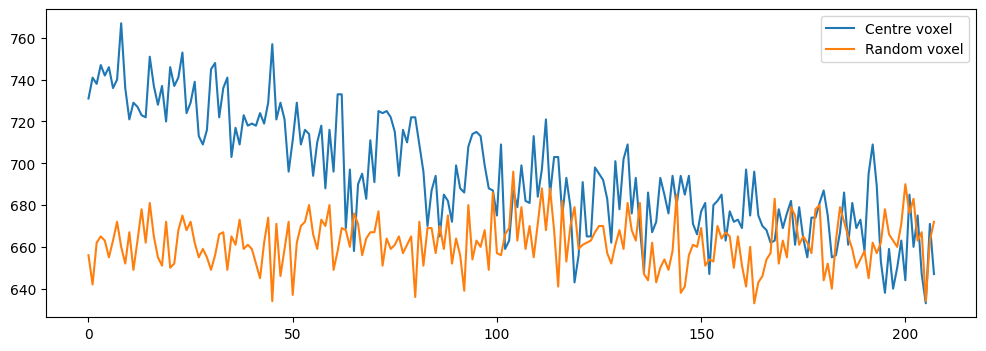

In [32]:
# Get the center voxel coordinates
bold_vox_center = np.array(bold_data.shape) / 2.
x, y, z, _ = bold_vox_center

# Set the plot size
plt.figure(figsize=(12, 4))

# Plot the central voxel's time course
plt.plot(bold_data[int(x), int(y), int(z), :])

# Plot a random voxel's time course
plt.plot(bold_data[44, 24, 18, :])

# Add legends to the plot
plt.legend(['Centre voxel', 'Random voxel'])

#### Method 2: Using Nilearn’s `NiftiSpheresMasker`

`NiftiSpheresMasker` is useful when working with coordinates in world space (e.g., MNI or scanner space). It allows us to extract time series from a single voxel or spheres centred at given coordinates. The input coordinates, in this case, must be in **world coordinates**.

Centre voxel in world space: [ 3.9803113   8.67662585 24.24573588]
Random voxel in world space: [-31.67795694 -15.41367427  16.8722758 ]


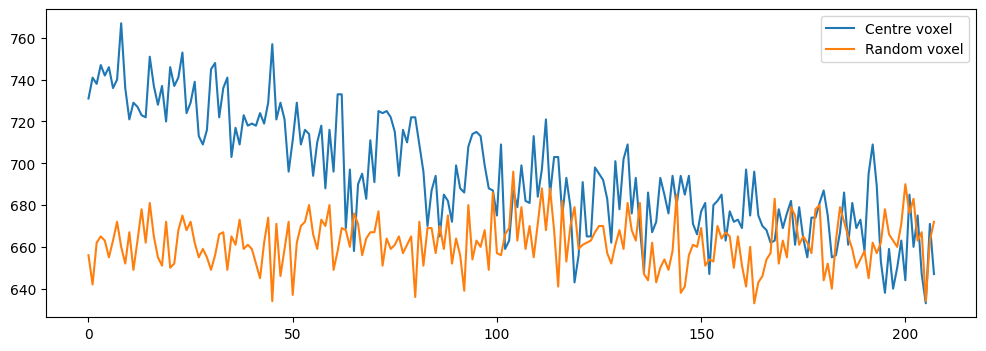

In [33]:
from nibabel.affines import apply_affine
from nilearn.maskers import NiftiSpheresMasker

# Convert the two previously used voxel coordinates to the world coordinates
bold_center_coords = apply_affine(bold_image.affine, [x, y, z])
random_voxel_coords = apply_affine(bold_image.affine, [44, 24, 18])

print(f"Centre voxel in world space: {bold_center_coords}")
print(f"Random voxel in world space: {random_voxel_coords}")

# Define masker and extract time series
coord_masker = NiftiSpheresMasker(
    [bold_center_coords, random_voxel_coords], 
    radius=0  # in mm, 0 = single voxel
)
coord_time_series = coord_masker.fit_transform(bold_image)

# Plot the time series of the center and random voxels
plt.figure(figsize=(12, 4))
plt.plot(coord_time_series)
plt.legend(['Centre voxel', 'Random voxel'])

## 🧠 EXERCISE

Locate and plot the brightest voxel in the mean BOLD image of sub-15, run-02 and visualise it on top of the subject's anatomical image.   
In the plot title, include both the world coordinates and the voxel's intensity value.  

💡**Tip:** `NumPy` function `np.max(data_array)` finds the highest value in a data array, and `np.unravel_index(argmax(data_array), data_array.shape)` returns the index of the highest value.

In [34]:
# Step 1: Select the image file


# Step 2: Get the mean image


# Step 3: Get the data from the mean image


# Step 4: Find the highest value in the mean image


# Step 5: Get the voxel index of the highest value


# Step 6: Convert the voxel index to MNI coordinates


# Step 7: Plot the mean BOLD image centered on the highest voxel and include the world coordinate and the voxel's intensity value in the title
